# Deep Dive: CRNN OCR Pipeline

This notebook provides a detailed walkthrough of the CRNN OCR pipeline, from data preparation to inference. We will visualize intermediate outputs, including the final feature map before CTC Loss, and explain the CTC Loss calculation in detail.

**Core Steps:**
1.  **Data Preparation**: Image processing and Label encoding.
2.  **Model Forward**: CNN Features -> Reshape -> RNN -> Logits.
3.  **Visualization**: Heatmap of the output Logits (Time vs Class).
4.  **CTC Loss**: Understanding the inputs and mechanism.
5.  **Inference**: Greedy Decoding.

## 1. Setup and Imports

In [1]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import sys

# Add src to path to import modules
sys.path.append('src')

from dataset import OCRDataset, get_vocab
from model import CRNN
from utils import decode_greedy, decode_beam_search

# Configuration
DATA_ROOT = 'data'
CHECKPOINT_PATH = 'checkpoints/best_model.pth'
IMG_HEIGHT = 32
IMG_WIDTH = 100 # Consistent with training
DEVICE = torch.device('cpu') # Use CPU for easier debugging/visualization

## 2. Data Preparation (Train/Val Split & Encoding)

**Goal**: Prepare the raw image and label for the network.

-   **Image**: Resize to (32, 100), Convert to Grayscale (1 channel), Normalize (-1, 1).
-   **Label**: Convert characters to integers using a Vocabulary Mapping.

The `OCRDataset` class handles this via `__getitem__`.

Vocabulary (38): ['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'c', 'j', 's', 'u', 'w', 'x', 'y']

Sample Index: 1
Image Shape: torch.Size([1, 32, 100]) (Channel, Height, Width)
Label Tensor: tensor([ 1,  2,  2, 16, 22,  2])
Label Length: 6
Encoded Label string: 233HP3


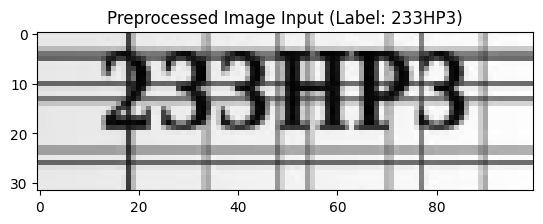

In [2]:
# 1. Get Vocabulary
vocab = get_vocab(os.path.join(DATA_ROOT, 'trainset'), os.path.join(DATA_ROOT, 'testset'))
print(f"Vocabulary ({len(vocab)}): {vocab}")

# 2. Initialize Dataset
train_ds = OCRDataset(os.path.join(DATA_ROOT, 'trainset'), vocab, height=IMG_HEIGHT, width=IMG_WIDTH)
idx2char = train_ds.idx2char

# 3. Get a sample
idx = 1  # Change this to see different samples
image_tensor, label_tensor, label_len = train_ds[idx]

print(f"\nSample Index: {idx}")
print(f"Image Shape: {image_tensor.shape} (Channel, Height, Width)")
print(f"Label Tensor: {label_tensor}")
print(f"Label Length: {label_len.item()}")
print(f"Encoded Label string: {''.join([idx2char[i.item()] for i in label_tensor])}")

# Visualize
plt.imshow(image_tensor.squeeze(), cmap='gray')
plt.title(f"Preprocessed Image Input (Label: {''.join([idx2char[i.item()] for i in label_tensor])})")
plt.axis('on')
plt.show()

## 3. Model Evolution: Early vs Converged

We will load the trained model and pass this single image through it. However, instead of just getting the final output, we will inspect the shapes at each major block.

### Pipeline Stages:
1.  **CNN Backbone**: Extracts visual features. Input: `(B, 1, 32, 100)` -> Output: `(B, 512, 1, 26)`.
    *   *Note*: The Height became 1 (vertical Information compressed), Width became 26 (Horizontal/Time information compressed but preserved).
    *   The width 26 corresponds to the number of "Timesteps" (T).
2.  **Reshape**: Prepare for RNN sequence. `(B, 512, 1, 26)` -> `(26, B, 512)` (Seq, Batch, Feature).
3.  **RNN Head**: Contextual sequence modeling. Output: `(26, B, Hidden*2)`.
4.  **Linear Projection**: Map to classes. Output: `(26, B, NumClasses)`.

We will compare the model's output at an early stage (Epoch 1) versus the fully converged state.


Loading Early Checkpoint: checkpoints/epoch1.pth


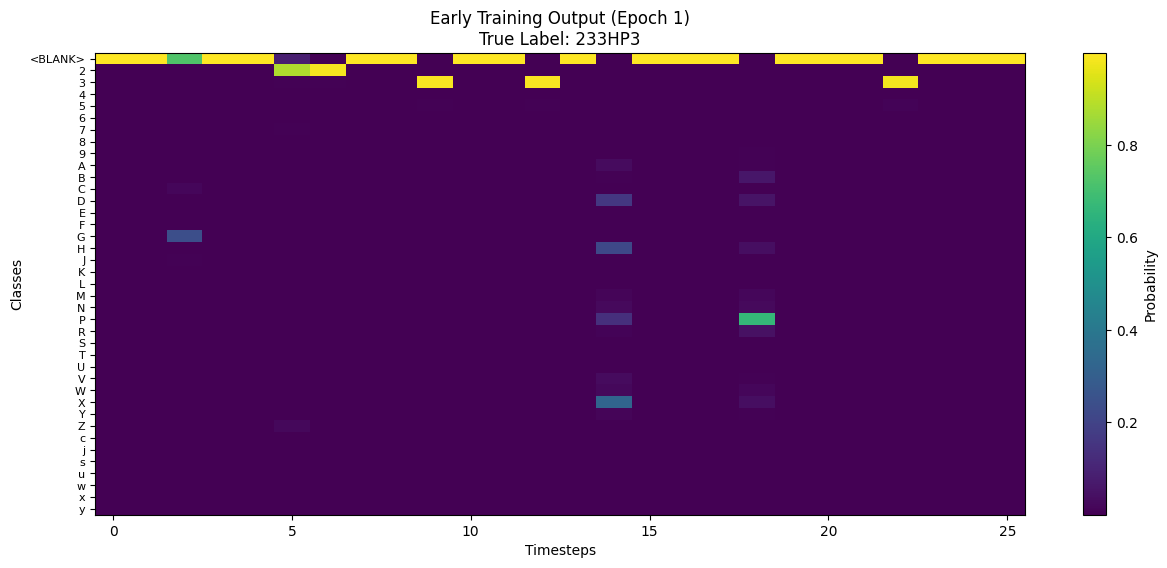

In [3]:
# --- 3a. EARLY TRAINING (Epoch 1) ---
# Load Epoch 1 Checkpoint
epoch1_path = 'checkpoints/epoch1.pth'
print(f"Loading Early Checkpoint: {epoch1_path}")

model_e1 = CRNN(IMG_HEIGHT, 1, len(vocab)+1, 256).to(DEVICE)
try:
    model_e1.load_state_dict(torch.load(epoch1_path, map_location=DEVICE))
except FileNotFoundError:
    print(f"Warning: {epoch1_path} not found. Skipping Epoch 1 visualization.")
    model_e1 = None

if model_e1:
    model_e1.to(DEVICE)
    model_e1.eval()

    # Forward Pass
    with torch.no_grad():
        # Add batch dimension: [1, 1, 32, 100]
        input_img = image_tensor.unsqueeze(0).to(DEVICE)
        rnn_output_e1 = model_e1(input_img) # [26, 1, 39]

    # Visualize Heatmap
    probs_e1 = rnn_output_e1.softmax(dim=2).squeeze(1).numpy().T # [Classes, Time]
    
    plt.figure(figsize=(15, 6))
    plt.imshow(probs_e1, aspect='auto', cmap='viridis', interpolation='nearest')
    
    # Y-axis
    tick_locs = np.arange(len(vocab)+1)
    tick_labels = ['<BLANK>'] + [idx2char[i] for i in range(1, len(vocab)+1)]
    plt.yticks(tick_locs, tick_labels, fontsize=8)
    
    plt.xlabel("Timesteps")
    plt.ylabel("Classes")
    plt.title(f"Early Training Output (Epoch 1)\nTrue Label: {''.join([idx2char[i.item()] for i in label_tensor])}")
    plt.colorbar(label="Probability")
    plt.show()



### 3b. Converged Model (Best Checkpoint)
Now let's see the output from our fully trained model.


In [4]:
# Load Model
n_class = len(vocab) + 1 # +1 for blank
model = CRNN(IMG_HEIGHT, 1, n_class, 256).to(DEVICE)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
model.eval()

# Prepare Input Batch (Batch Size = 1)
input_batch = image_tensor.unsqueeze(0).to(DEVICE) # [1, 1, 32, 100]

print("---- Forward Pass Tracking ----")
print(f"1. Input: {input_batch.shape}")

# A. CNN Pass
with torch.no_grad():
    cnn_features = model.cnn(input_batch)
print(f"2. CNN Output features: {cnn_features.shape} (Batch, Channel, Height, Width)")

# B. Pre-RNN Reshape
b, c, h, w = cnn_features.size()
assert h == 1, "Height must be 1"
reshaped_features = cnn_features.squeeze(2) # [B, C, W]
reshaped_features = reshaped_features.permute(2, 0, 1) # [W, B, C] -> [Time, Batch, Feature]
print(f"3. Input to RNN (Permuted): {reshaped_features.shape} (Time, Batch, Feature)")

# C. RNN Pass
with torch.no_grad():
    rnn_output = model.rnn(reshaped_features)
print(f"4. Model Output (Logits): {rnn_output.shape} (Time, Batch, NumClasses)")

---- Forward Pass Tracking ----
1. Input: torch.Size([1, 1, 32, 100])
2. CNN Output features: torch.Size([1, 512, 1, 26]) (Batch, Channel, Height, Width)
3. Input to RNN (Permuted): torch.Size([26, 1, 512]) (Time, Batch, Feature)
4. Model Output (Logits): torch.Size([26, 1, 39]) (Time, Batch, NumClasses)


## 4. Visualizing the Output (Features/Logits)

This is the requested plot: **The feature map / output of the final layer before CTC Loss**.

We have a matrix of shape `[Time (26), Class (39)]`. Each column represents a timestep, and each row represents the probability of a specific character at that timestep.

**How to read the plot:**
-   **Y-axis**: The Characters (Classes). Index 0 is usually `Blank`.
-   **X-axis**: Time steps (0 to 25).
-   **Color**: Probability (Softmax) of that character at that time.
-   **Bright Spots**: The model is confident that character is present at that rough horizontal location in the image.

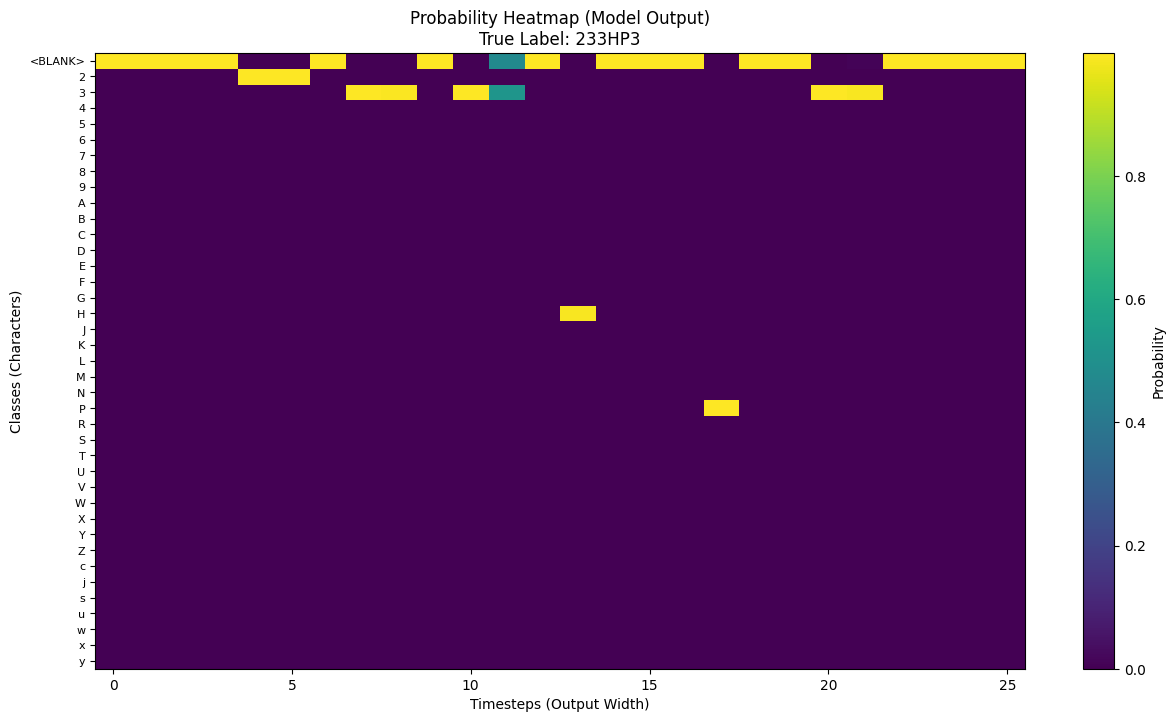

In [5]:
# Apply Softmax to convert Logits to Probabilities for visualizing
probs = rnn_output.softmax(dim=2).squeeze(1).numpy() # [Time, Classes]
probs = probs.T # Transpose for plotting: [Classes, Time]

# Setup Plot
plt.figure(figsize=(15, 8))
plt.imshow(probs, aspect='auto', cmap='viridis', interpolation='nearest')

# Annotate Y-axis with characters
tick_locs = np.arange(n_class)
tick_labels = ['<BLANK>'] + [idx2char[i] for i in range(1, n_class)]
plt.yticks(tick_locs, tick_labels, fontsize=8)

plt.xlabel("Timesteps (Output Width)")
plt.ylabel("Classes (Characters)")
plt.title(f"Probability Heatmap (Model Output)\nTrue Label: {''.join([idx2char[i.item()] for i in label_tensor])}")
plt.colorbar(label="Probability")
plt.show()

## 5. CTC Loss Calculation (Deep Dive)

**The Challenge**: 
The model output is a sequence of probabilities for every timestep (Width=26), but our ground truth label is a sequence of characters (e.g., "MXPTU3", Length=6). 
-   We do **not** know exactly which timestep corresponds to which character.
-   For example, does the 'M' appear at step 0, 1, or 2?

**The Solution (CTC Loss)**: 
Connectionist Temporal Classification (CTC) solves this by considering **all possible alignments** (paths) that could validly collapse into the target label. It sums their probabilities to get the probability of the label given the input.

## 5a. Verification with PyTorch
First, we calculate the loss using the standard PyTorch implementation.

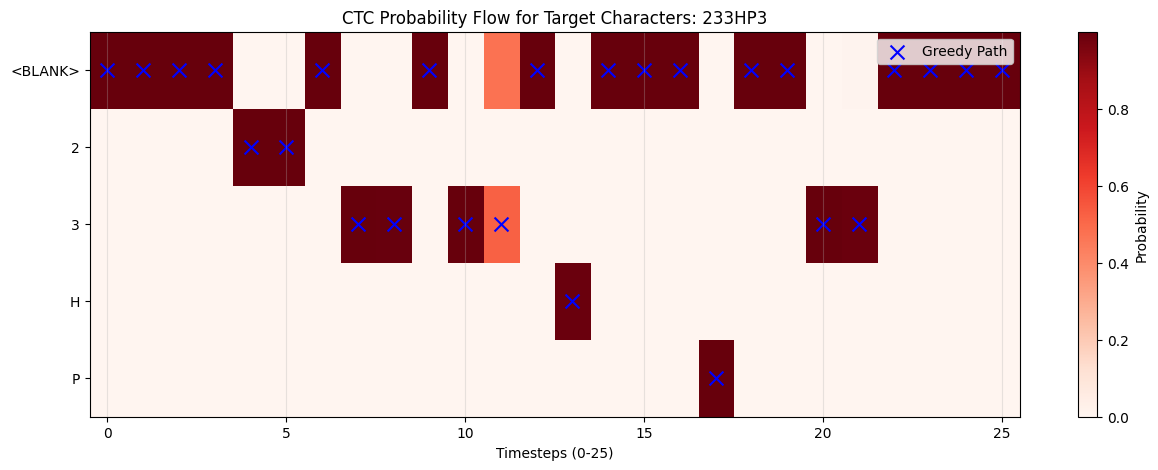

In [6]:
# --- VISUALIZATION: PROBABILITY FLOW FOR TARGET ---
# This plot shows the probabilities ONLY for the characters in the Ground Truth Label.
# It helps visualize the "Valid Paths" CTC is traversing.

# 1. Get relevant characters (Target + Blank)
target_indices = label_tensor.tolist()
unique_indices = sorted(list(set([0] + target_indices))) # 0 is Blank
subset_labels = ['<BLANK>'] + [idx2char[i] for i in unique_indices if i != 0]

# 2. Extract specific rows from the Probability Matrix
# probs shape was [Classes, Time]. We select specific classes.
subset_probs = probs[unique_indices, :] 

# 3. Plot
plt.figure(figsize=(15, 5))
plt.imshow(subset_probs, aspect='auto', cmap='Reds', interpolation='nearest')
plt.yticks(range(len(unique_indices)), subset_labels)
plt.xlabel("Timesteps (0-25)")
plt.title(f"CTC Probability Flow for Target Characters: {''.join([idx2char[i] for i in target_indices])}")
plt.colorbar(label="Probability")

# Overlay Best Path (Greedy)
best_path_indices = rnn_output.argmax(2).squeeze(1).tolist()
for t, char_idx in enumerate(best_path_indices):
    if char_idx in unique_indices:
        y_pos = unique_indices.index(char_idx)
        plt.scatter(t, y_pos, color='blue', s=100, marker='x', label='Greedy Path' if t==0 else "")

plt.legend(loc='upper right')
plt.grid(axis='x', alpha=0.3)
plt.show()

In [7]:
criterion = nn.CTCLoss(blank=0, zero_infinity=True)

# 1. Prepare Log Probs (Required by PyTorch CTC)
log_probs = rnn_output.log_softmax(2) # [Time, Batch, Class]
print(f"Log Probs Shape: {log_probs.shape}")

# 2. Prepare Targets
targets = label_tensor # [Label Len]
print(f"Targets: {targets}")

# 3. Input Lengths (The 'T' dimension)
T = log_probs.size(0)
input_lengths = torch.LongTensor([T]) # [26]
print(f"Input Lengths: {input_lengths}")

# 4. Target Lengths
target_lengths = label_len # [Len]
print(f"Target Lengths: {target_lengths}")

# Calculate Loss
loss = criterion(log_probs, targets, input_lengths, target_lengths)
print(f"\nCalculated CTC Loss: {loss.item():.4f}")

Log Probs Shape: torch.Size([26, 1, 39])
Targets: tensor([ 1,  2,  2, 16, 22,  2])
Input Lengths: tensor([26])
Target Lengths: tensor([6])

Calculated CTC Loss: 0.0024


## 5b. CTC Internals: The Forward Algorithm

To understand how CTC sums all valid paths efficiently, we can implement the **Forward Algorithm** in Python. This recreates the logic inside PyTorch's C++ `nn.CTCLoss` (see [LossCTC.cpp](https://github.com/pytorch/pytorch/blob/main/aten/src/ATen/native/LossCTC.cpp)).

### Key Concepts for Sample "MXPTU3":
1.  **Extended Target ($L'$):** 
    CTC inserts a "Blank" token ( `-` ) between every character. 
    -   "MXPTU3" $\rightarrow$ `- M - X - P - T - U - 3 -`
    -   This allows the model to output repeated characters (e.g. `MM`) vs single characters separated by blanks.
2.  **Alpha Matrix ($\alpha_{t,s}$):**
    -   We compute a matrix where $\alpha_{t,s}$ represents the probability of having aligned the first $s$ symbols of the extended target by time $t$.
    -   We simply sum probabilities from valid previous states (Stay, Move Next, or Skip Blank).

The code below calculates the **Negative Log Likelihood** manually and compares it with PyTorch.

Running Python CTC Implementation...
log_probs shape:  torch.Size([26, 1, 39])
log_probs_t:  tensor([[-6.9141e-06, -1.4427e+01, -1.5051e+01,  ..., -1.6787e+01,
         -1.5029e+01, -1.6127e+01],
        [-1.4305e-06, -1.5854e+01, -1.6054e+01,  ..., -1.8908e+01,
         -1.6806e+01, -1.8174e+01],
        [-1.0729e-06, -1.6066e+01, -1.6228e+01,  ..., -1.9346e+01,
         -1.7003e+01, -1.8587e+01],
        ...,
        [-1.1921e-06, -1.5993e+01, -1.5777e+01,  ..., -1.9529e+01,
         -1.7333e+01, -1.8494e+01],
        [-1.1921e-06, -1.6372e+01, -1.6288e+01,  ..., -1.9120e+01,
         -1.6534e+01, -1.8267e+01],
        [-8.2254e-06, -1.4512e+01, -1.4500e+01,  ..., -1.7109e+01,
         -1.4294e+01, -1.6317e+01]])
extended_target:  tensor([ 0,  1,  0,  2,  0,  2,  0, 16,  0, 22,  0,  2,  0])
alpha matrix shape:  torch.Size([26, 13])
alpha matrix:  tensor([[-6.9141e-06, -1.4427e+01,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf,        -inf,     

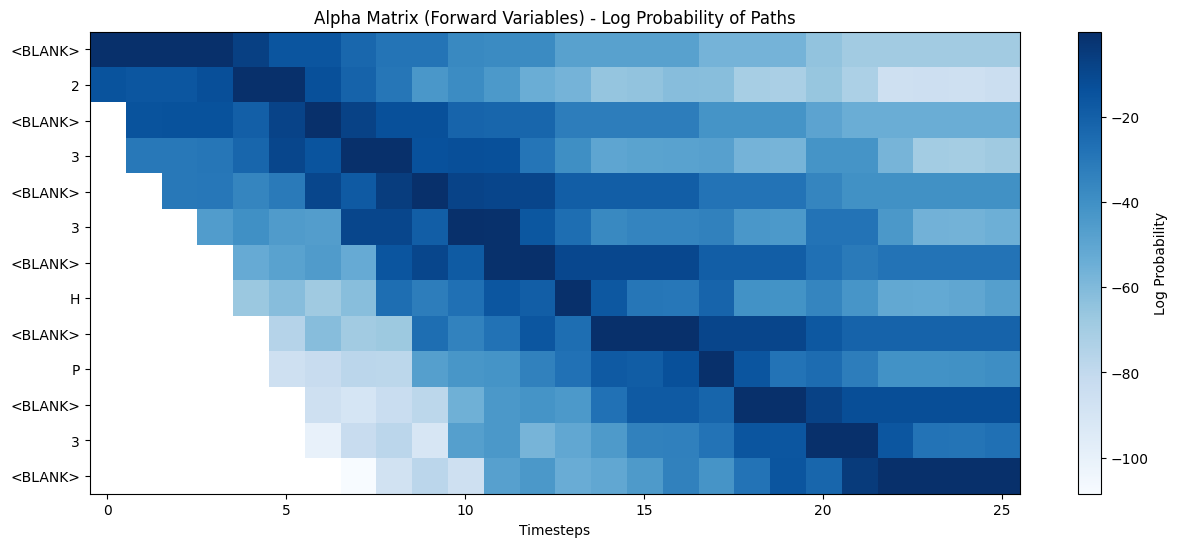

In [8]:
# Pure Python Implementation of CTC Forward Algorithm

def ctc_loss_python(log_probs, targets, input_lengths, target_lengths, blank=0):
    """
    Python implementation of CTC Loss (Forward Algorithm only).
    Returns: loss (nll), alpha indices (for visualization)
    """
    # Assuming Batch Size = 1
    log_probs_t = log_probs[:, 0, :] # [T, C]
    print("log_probs shape: ", log_probs.shape)
    print("log_probs_t: ", log_probs_t)
    target = targets # [L]
    T = input_lengths[0].item()
    L = target_lengths[0].item()
    
    # 1. Extend Target with Blanks: 1, 2 -> 0, 1, 0, 2, 0
    extended_target = [blank]
    for char in target:
        extended_target.append(char.item())
        extended_target.append(blank)
    extended_target = torch.tensor(extended_target, dtype=torch.long)
    S = len(extended_target)
    print("extended_target: ", extended_target)
    
    # 2. Alpha Matrix (in Log Space)
    alpha = torch.full((T, S), -float('inf'))
    
    # Init (t=0): Can start at blank or first char
    alpha[0, 0] = log_probs_t[0, extended_target[0]]
    if S > 1:
        alpha[0, 1] = log_probs_t[0, extended_target[1]]
    
    print("alpha matrix shape: ", alpha.shape)
    print("alpha matrix: ", alpha)

    # 3. Dynamic Programming
    for t in range(1, T):
        for s in range(S):
            char_idx = extended_target[s]
            
            # Sources: stay (s), move (s-1), skip-blank (s-2)
            # LogAddExp is essentially: log(e^a + e^b)
            
            # 1. Stay
            log_p = alpha[t-1, s]
            
            # 2. Move from previous
            if s > 0:
                log_p = torch.logaddexp(log_p, alpha[t-1, s-1])
            
            # 3. Skip Blank
            if s > 1 and extended_target[s] != blank and extended_target[s] != extended_target[s-2]:
                log_p = torch.logaddexp(log_p, alpha[t-1, s-2])
                
            alpha[t, s] = log_p + log_probs_t[t, char_idx]
            
    # 4. Final Loss: Sum of last two states (last blank or last char)
    if S > 1:
        total_log_prob = torch.logaddexp(alpha[T-1, S-1], alpha[T-1, S-2])
    else:
        total_log_prob = alpha[T-1, S-1]
        
    return -total_log_prob, alpha

# Run Python Implementation
print("Running Python CTC Implementation...")
python_loss, alpha_matrix = ctc_loss_python(log_probs, targets, input_lengths, target_lengths)
print(f"Python Calculated Loss (Raw NLL): {python_loss.item():.4f}")

# NOTE: PyTorch nn.CTCLoss default reduction is 'mean', which divides by target_length
pytorch_loss_val = loss.item()
target_len = target_lengths[0].item()

# Normalize Python Loss to match PyTorch 'mean' reduction
python_loss_mean = python_loss / target_len
print(f"Python Loss (Normalized by Target Length {target_len}): {python_loss_mean.item():.4f}")
print(f"PyTorch Calculated Loss: {pytorch_loss_val:.4f}")

diff = abs(python_loss_mean.item() - pytorch_loss_val)
if diff < 1e-4:
    print(f"✅ Implementation MATCHES PyTorch! ({python_loss_mean.item():.6f} vs {pytorch_loss_val:.6f})")
else:
    print(f"❌ Implementation MISMATCH. Diff: {diff}")

# Visualize Alpha Matrix
plt.figure(figsize=(15, 6))
# Convert S-axis labels to chars
extended_chars = ['<BLANK>']
for char_idx in targets:
    extended_chars.append(idx2char[char_idx.item()])
    extended_chars.append('<BLANK>')

plt.imshow(alpha_matrix.detach().numpy().T, aspect='auto', cmap='Blues', interpolation='nearest')
plt.yticks(range(len(extended_chars)), extended_chars)
plt.xlabel("Timesteps")
plt.title("Alpha Matrix (Forward Variables) - Log Probability of Paths")
plt.colorbar(label="Log Probability")
plt.show()

## 5c. CTC Internals: Backward Pass & Gradients

How does the model learn?
To update weights, we need the gradients. CTC computes the gradient for each node $(t, s)$ based on the probability that **valid paths flow through that node**.

1.  **Beta Matrix ($\beta_{t,s}$):** The Backward probability (similar to Alpha but from the end).
2.  **Soft Alignment ($\gamma$):** 
    -   By multiplying Forward ($\alpha$) and Backward ($\beta$) probabilities, we find the probability of being at state $s$ at time $t$ given the entire sequence label.
    -   $\text{Alignment}_{t,s} \propto \alpha_{t,s} \cdot \beta_{t,s}$

**Visualization:**
The plot below shows this "Soft Alignment". The brightly colored path represents the most likely alignment of "MXPTU3" against the 26 timesteps. This heatmap effectively tells the model: *"You should have predicted 'M' here, 'X' there, etc."*

Calculating Beta Matrix...


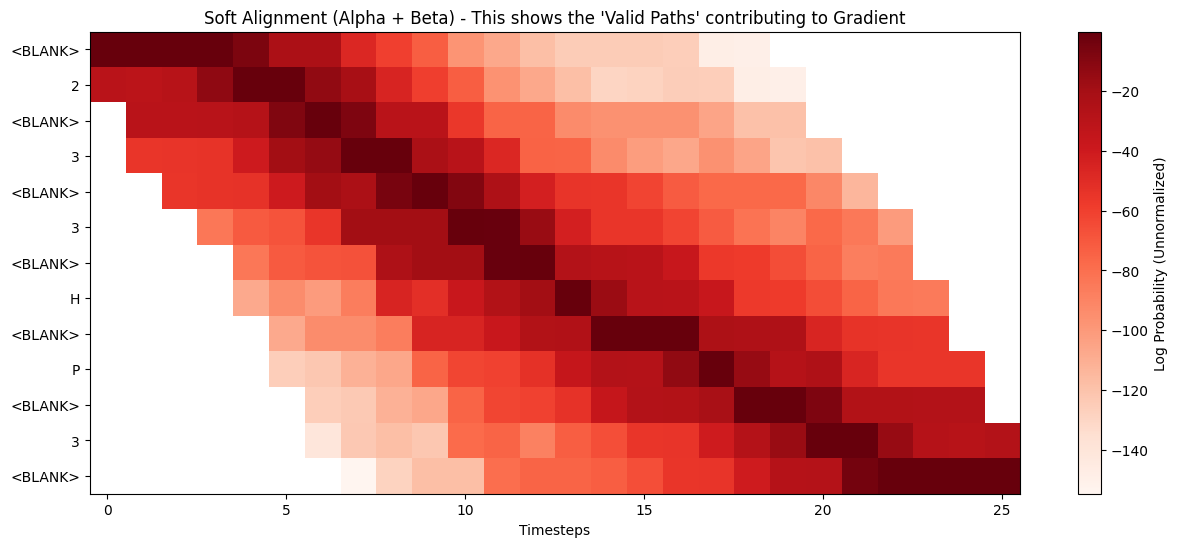

In [9]:
# --- SECTION 5c: CTC BACKWARD (Gradients) ---
# To calculate gradients, CTC uses the Backward Algorithm (Beta Matrix).
# Beta[t, s] = Probability of completing the target from state s at time t to the end.

def ctc_backward_python(log_probs, targets, input_lengths, target_lengths, blank=0):
    # Assuming Batch Size = 1
    log_probs_t = log_probs[:, 0, :] # [T, C]
    target = targets # [L]
    T = input_lengths[0].item()
    L = target_lengths[0].item()
    
    # Extend Target (Same as Forward)
    extended_target = [blank]
    for char in target:
        extended_target.append(char.item())
        extended_target.append(blank)
    extended_target = torch.tensor(extended_target, dtype=torch.long)
    S = len(extended_target)
    
    # Initialize Beta Matrix (Log Space)
    beta = torch.full((T, S), -float('inf'))
    
    # Init (t=T-1): Can end at last blank (S-1) or last char (S-2)
    # Note: In backward, we don't multiply by log_probs at T-1 yet (convention varies, but standard is initialized to 0 log-prob)
    # or we can view alpha*beta as the total prob. Let's align with standard Derivations.
    # Standard: Beta(T-1, S-1) = 1 (log 0), Beta(T-1, S-2) = 1 (log 0)
    beta[T-1, S-1] = 0.0
    if S > 1:
        beta[T-1, S-2] = 0.0
        
    # Dynamic Programming (Backward Pass)
    for t in range(T-2, -1, -1):
        # We look ahead to t+1
        for s in range(S):
            char_idx = extended_target[s]
            
            # Sources from t+1: 
            # 1. Stay (s): came from beta[t+1, s]
            # 2. Next (s+1): came from beta[t+1, s+1]
            # 3. Skip (s+2): came from beta[t+1, s+2]
            
            # Transition 1: From s at t+1 (Stay)
            # To be consistent with Alpha, we multiply by the probability of the character at t+1
            log_p = beta[t+1, s] + log_probs_t[t+1, extended_target[s]]
            
            # Transition 2: From s+1 at t+1 (Next State)
            if s < S - 1:
                log_p = torch.logaddexp(log_p, beta[t+1, s+1] + log_probs_t[t+1, extended_target[s+1]])
                
            # Transition 3: From s+2 at t+1 (Skip Blank)
            if s < S - 2 and extended_target[s] != blank and extended_target[s] != extended_target[s+2]:
                log_p = torch.logaddexp(log_p, beta[t+1, s+2] + log_probs_t[t+1, extended_target[s+2]])
                
            beta[t, s] = log_p
            
    return beta

print("Calculating Beta Matrix...")
beta_matrix = ctc_backward_python(log_probs, targets, input_lengths, target_lengths)

# Calculate Soft Alignment (Gradients)
# Probability of being at state s at time t given the full sequence
# P(s, t | X) = (alpha[t, s] * beta[t, s]) / P(Label | X)
# In Log Space: log_gamma = alpha + beta - log_total_prob

log_gamma = alpha_matrix + beta_matrix
# Note: alpha[t,s] includes log_probs[t], beta[t,s] includes log_probs[t+1:]
# So alpha + beta counts log_probs[t] once. This is correct.
# However, typically Beta is defined slightly differently depending on implementation.
# Let's check visualization. The valid path should 'light up'.

plt.figure(figsize=(15, 6))
plt.imshow(log_gamma.detach().numpy().T, aspect='auto', cmap='Reds', interpolation='nearest')
plt.title("Soft Alignment (Alpha + Beta) - This shows the 'Valid Paths' contributing to Gradient")
plt.yticks(range(len(extended_chars)), extended_chars)
plt.xlabel("Timesteps")
plt.colorbar(label="Log Probability (Unnormalized)")
plt.show()

## 6. Inference: Greedy Decoding

Finally, to get the prediction text from the logits, we use a decoding strategy.

**Greedy Decoding** is the simplest method:
1.  **Argmax**: At each timestep, pick the class with the highest probability.
2.  **Collapse**: Merge adjacent repeated characters (e.g. `AA` $\rightarrow$ `A`).
3.  **Remove Blanks**: Discard any Blank tokens.

This is fast but not always optimal (Beam Search is better for complex language models). For OCR, Greedy is often sufficient.

In [10]:
# 1. Argmax path
preds_indices = rnn_output.argmax(2).squeeze(1).tolist() # [Time]
print(f"Raw Path Indices (Best per timestep): {preds_indices}")

# 2. Convert to Chars (for visualization)
# Note: We handle 0 as <BLANK>
raw_chars = []
for idx in preds_indices:
    if idx == 0:
        raw_chars.append('-') # Using '-' for blank visualization
    else:
        raw_chars.append(idx2char[idx])
print(f"Raw Path String: {''.join(raw_chars)}")

# 3. Decoding Logic (Included in utils.decode_greedy)
decoded_text = decode_greedy(rnn_output, idx2char)[0]
print(f"\nFinal Decoded Text: {decoded_text}")
print(f"Ground Truth: {''.join([idx2char[i.item()] for i in label_tensor])}")

if decoded_text == ''.join([idx2char[i.item()] for i in label_tensor]):
    print("\nSUCCESS: Prediction matches Ground Truth!")
else:
    print("\nMISMATCH: Prediction incorrect.")

Raw Path Indices (Best per timestep): [0, 0, 0, 0, 1, 1, 0, 2, 2, 0, 2, 2, 0, 16, 0, 0, 0, 22, 0, 0, 2, 2, 0, 0, 0, 0]
Raw Path String: ----22-33-33-H---P--33----

Final Decoded Text: 233HP3
Ground Truth: 233HP3

SUCCESS: Prediction matches Ground Truth!


## 7. Inference: Beam Search Decoding

Beam Search is a more sophisticated decoding method that maintains multiple hypothesis paths (the "beam") at each timestep.

-   It explores the search space more thoroughly than Greedy Decoding.
-   It is useful when the simple "best character per timestep" approach fails due to ambiguity.

In [11]:
# Run Beam Search
beam_width = 10
decoded_text_beam = decode_beam_search(rnn_output, idx2char, beam_width=beam_width)[0]

print(f"Beam Search Output (Beam Width {beam_width}): {decoded_text_beam}")
print(f"Greedy Output: {decoded_text}")
print(f"Ground Truth: {''.join([idx2char[i.item()] for i in label_tensor])}")

if decoded_text_beam == ''.join([idx2char[i.item()] for i in label_tensor]):
    print("\nSUCCESS: Beam Search Prediction matches Ground Truth!")
else:
    print("\nMISMATCH: Beam Search Prediction incorrect.")

Beam Search Output (Beam Width 10): 233HP3
Greedy Output: 233HP3
Ground Truth: 233HP3

SUCCESS: Beam Search Prediction matches Ground Truth!
